In [1]:
'''
Bewley-Huggett-Aiyagari model

Finite difference method adapted from https://benjaminmoll.com/codes/ HJB_simple.m
'''
import os
import time
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from deep_macrofin import (ActivationType, Comparator, LossReductionMethod, OptimizerType, PDEModelTimeStep, 
                           SamplingMethod, set_seeds)


plt.rcParams["font.size"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10

In [2]:
def utility(c, gamma):
    if gamma == 1:
        return np.log(c)
    else:
        return c**(1-gamma)/(1-gamma)

def utility_deriv(c, gamma):
    if gamma == 1:
        return 1 / c
    else:
        return c**(-gamma)

def inverse_marginal_deriv(dV, gamma):
    if gamma == 1:
        return 1 / dV
    else:
        return dV**(-1/gamma)

def solve_upwind(gamma, r, y, rho, N, max_iter=10000, crit=1e-6):
    '''
    Inputs:
    - gamma: risk aversion
    - r: interest rate
    - y: income
    - rho: discount rate
    - N: grid count
    - max_iter: maximum number of iterations
    - crit: error threshold
    '''
    amin = 0.01
    amax = 1.0
    a = np.linspace(amin, amax, N)
    da = (amax - amin) / (N - 1)

    dVf = np.zeros(N)
    dVb = np.zeros(N)
    c = np.zeros(N)

    # Initial guess
    c0 = r * a + y
    v0 = utility(c0, gamma) / rho
    v = v0.copy()

    dist = np.zeros(max_iter)
    for n in range(max_iter):
        V = v.copy()

        # Forward difference
        dVf[:-1] = (V[1:] - V[:-1]) / da
        dVf[-1] = 0  # Never used

        # Backward difference
        dVb[1:] = (V[1:] - V[:-1]) / da
        dVb[0] = utility_deriv(r*amin + y, gamma)  # State constraint boundary condition

        I_concave = dVb > dVf

        # Consumption and savings
        cf = inverse_marginal_deriv(dVf, gamma)
        muf = r*a + y - cf

        cb = inverse_marginal_deriv(dVb, gamma)
        mub = r*a + y - cb

        c0 = r*a + y
        dV0 = c0 ** (-gamma)

        # Upwind scheme
        If = muf > 0
        Ib = mub < 0
        I0 = ~(If | Ib)

        # Ib[0] = False
        # If[0] = True
        Ib[-1] = True
        If[-1] = False

        dV_Upwind = dVf * If + dVb * Ib + dV0 * I0

        c = inverse_marginal_deriv(dV_Upwind, gamma)
        Vchange = utility(c, gamma) + dV_Upwind * (r * a + y - c) - rho * V

        # Update
        DeltaT = 0.9 * da / np.max(r * a + y)
        v += DeltaT * Vchange

        dist[n] = np.max(np.abs(Vchange))
        if dist[n] < crit:
            print(f'Value Function Converged, Iteration = {n}')
            break
    return a, v, c

In [3]:
def get_model(params: Dict[str, float], training_config: Dict[str, Dict], model_configs: Dict[str, Dict], seed=0, init_guess={"V": -170, "c": 0.13}):
    set_seeds(seed)
    model = PDEModelTimeStep("bha", config=training_config)
    model.set_state(["a"], {"a": [0.01, 1.0]}) #  
    model.add_params(params)
    model.add_endog("V", config=model_configs["V"])
    model.add_endog("c", config=model_configs["c"])
    if params["gamma"] == 1:
        endog_cond = torch.log(torch.tensor(params["y"], dtype=torch.float32, device=model.device))
        utility_eq = "u=log(c)"
    else:
        endog_cond = params["y"]**(1-params["gamma"]) / ((1-params["gamma"]) * params["rho"])
        utility_eq = "u=c**(1-gamma)/(1-gamma)"
    zero_a_bd = torch.zeros((100, 2), device=model.device)
    zero_a_bd[:, 1] = torch.linspace(0, 1, 100)
    model.add_endog_condition("V", 
                                "V(SV)", 
                                {"SV": zero_a_bd},
                                Comparator.EQ,
                                "ec", {"ec": endog_cond},
                                label="v1")
    model.add_endog_condition("c", 
                                "c(SV)", 
                                {"SV": zero_a_bd},
                                Comparator.EQ,
                                "y", params,
                                label="c1")
    model.add_equation("s=r*a+y-c")
    model.add_equation(utility_eq)
    model.add_endog_equation("c**(-gamma)=V_a")
    model.add_constraint("c_a", Comparator.GEQ, "0")
    model.add_hjb_equation("V_t + u+ V_a * s-rho*V")

    def init_guess_c(SV, r, y):
        a = SV[:, :1]
        return (r*a + y).detach()
    def init_guess_V(SV, r, y, gamma, rho):
        a = SV[:, :1]
        c = r*a + y
        return (c**(1-gamma)/((1-gamma)*rho)).detach()

    model.set_initial_guess({
        "V": lambda SV: init_guess_V(SV, params["r"], params["y"], params["gamma"], params["rho"]),
        "c": lambda SV: init_guess_c(SV, params["r"], params["y"])
    })
    return model

In [ ]:
PARAMS = {
    "gamma": 2, # Risk aversion
    "r": 0.045, # interest rate
    "y": 0.1, # income
    "rho": 0.05, # Discount rate
}
TRAINING_CONFIGS = {
    "num_outer_iterations": 10, 
    "num_inner_iterations": 10000, 
    "time_batch_size": 4, 
    "optimizer_type": OptimizerType.Adam,
    "sampling_method": SamplingMethod.UniformRandom,
    "time_boundary_loss_reduction": LossReductionMethod.MSE,
}
MODEL_CONFIGS = {
    "V": {"hidden_units": [64] * 3},
    "c": {"hidden_units": [32] * 3, "positive": True, "activation_type": ActivationType.SiLU},
}
BASE_DIR = "models/bha/"
os.makedirs(BASE_DIR, exist_ok=True)
print("{0:=^80}".format("loading FD solutions"))
if not os.path.exists(f"{BASE_DIR}/bha_fd.npz"):
    a, v, c = solve_upwind(PARAMS["gamma"], PARAMS["r"], PARAMS["y"], 
                        PARAMS["rho"], 100)
    np.savez(f"{BASE_DIR}/bha_fd.npz", a=a, v=v, c=c)
fd_res = np.load(f"{BASE_DIR}/bha_fd.npz")

==============================loading FD solutions==============================


In [5]:
model = get_model(PARAMS, TRAINING_CONFIGS, MODEL_CONFIGS, 0)
if not os.path.exists(f"{BASE_DIR}/model.pt"):
    model.train_model(BASE_DIR, f"model.pt", True)
    model.eval_model(True)
else:
    model.load_model(torch.load(f"{BASE_DIR}/model.pt", weights_only=False, map_location=model.device))
    model.eval_model(True)

d:\Research\continuous-time-eco-models\venv\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


====================================Training====================================


Min loss: 0.0532: 100%|██████████| 10000/10000 [05:15<00:00, 31.70it/s]   


Model loaded
V: Mean Value: -164.36066, Absolute Change: 0.07668, Relative Change:  0.00043
c: Mean Value: 0.12951, Absolute Change: 0.00636, Relative Change:  0.05216
Updating min loss from inf to 0.0537
Outer Loop 0 Finished in 315.5049s. Loading best model...


Min loss: 0.0103: 100%|██████████| 7071/7071 [03:36<00:00, 32.65it/s]


Model loaded
V: Mean Value: -164.33401, Absolute Change: 0.04077, Relative Change:  0.00024
c: Mean Value: 0.12966, Absolute Change: 0.00059, Relative Change:  0.00468
Updating min loss from 0.0537 to 0.0103
Outer Loop 1 Finished in 216.5993s. Loading best model...


Min loss: 0.0018: 100%|██████████| 5773/5773 [02:50<00:00, 33.89it/s]


Model loaded
V: Mean Value: -164.31706, Absolute Change: 0.01980, Relative Change:  0.00012
c: Mean Value: 0.12980, Absolute Change: 0.00026, Relative Change:  0.00186
Updating min loss from 0.0103 to 0.0022
Outer Loop 2 Finished in 170.3359s. Loading best model...


Min loss: 0.0007: 100%|██████████| 5000/5000 [02:19<00:00, 35.75it/s]


Model loaded
V: Mean Value: -164.29918, Absolute Change: 0.01864, Relative Change:  0.00011
c: Mean Value: 0.12989, Absolute Change: 0.00015, Relative Change:  0.00109
Updating min loss from 0.0022 to 0.0007
Outer Loop 3 Finished in 139.8613s. Loading best model...


Min loss: 0.0012: 100%|██████████| 4472/4472 [02:03<00:00, 36.22it/s]


Model loaded
V: Mean Value: -164.27971, Absolute Change: 0.01946, Relative Change:  0.00012
c: Mean Value: 0.12991, Absolute Change: 0.00014, Relative Change:  0.00109
Outer Loop 4 Finished in 123.4677s. Loading best model...


Min loss: 0.0011: 100%|██████████| 4082/4082 [01:55<00:00, 35.33it/s]


Model loaded
V: Mean Value: -164.26164, Absolute Change: 0.01808, Relative Change:  0.00011
c: Mean Value: 0.12993, Absolute Change: 0.00006, Relative Change:  0.00040
Outer Loop 5 Finished in 115.5338s. Loading best model...


Min loss: 0.0003: 100%|██████████| 3779/3779 [01:46<00:00, 35.52it/s]


Model loaded
V: Mean Value: -164.24580, Absolute Change: 0.01583, Relative Change:  0.00010
c: Mean Value: 0.12993, Absolute Change: 0.00006, Relative Change:  0.00046
Updating min loss from 0.0007 to 0.0003
Outer Loop 6 Finished in 106.3764s. Loading best model...


Min loss: 0.0003: 100%|██████████| 3535/3535 [01:31<00:00, 38.54it/s]


Model loaded
V: Mean Value: -164.22952, Absolute Change: 0.01626, Relative Change:  0.00010
c: Mean Value: 0.12993, Absolute Change: 0.00005, Relative Change:  0.00042
Outer Loop 7 Finished in 91.7195s. Loading best model...


Min loss: 0.0007: 100%|██████████| 3333/3333 [01:39<00:00, 33.42it/s]


Model loaded
V: Mean Value: -164.21451, Absolute Change: 0.01503, Relative Change:  0.00009
c: Mean Value: 0.12992, Absolute Change: 0.00004, Relative Change:  0.00035
Outer Loop 8 Finished in 99.7465s. Loading best model...


Min loss: 0.0003: 100%|██████████| 3162/3162 [01:23<00:00, 37.92it/s]


Model loaded
V: Mean Value: -164.20146, Absolute Change: 0.01303, Relative Change:  0.00008
c: Mean Value: 0.12991, Absolute Change: 0.00003, Relative Change:  0.00027
Outer Loop 9 Finished in 83.3806s. Loading best model...
training finished, total time :: 1463.5225257873535
Best model saved to models/bha//model_best.pt if valid
Model saved to models/bha//model.pt
===================================Evaluating===================================
loss :: endogvar_V_cond_v1: 0.0000,
endogvar_c_cond_c1: 0.0000,
endogeq_1: 0.0002,
constraint_1: 0.0001,
hjbeq_1: 0.0001,
endogvar_V_cond_time_boundary: 0.0000,
endogvar_c_cond_time_boundary: 0.0000,
total_loss: 0.0004


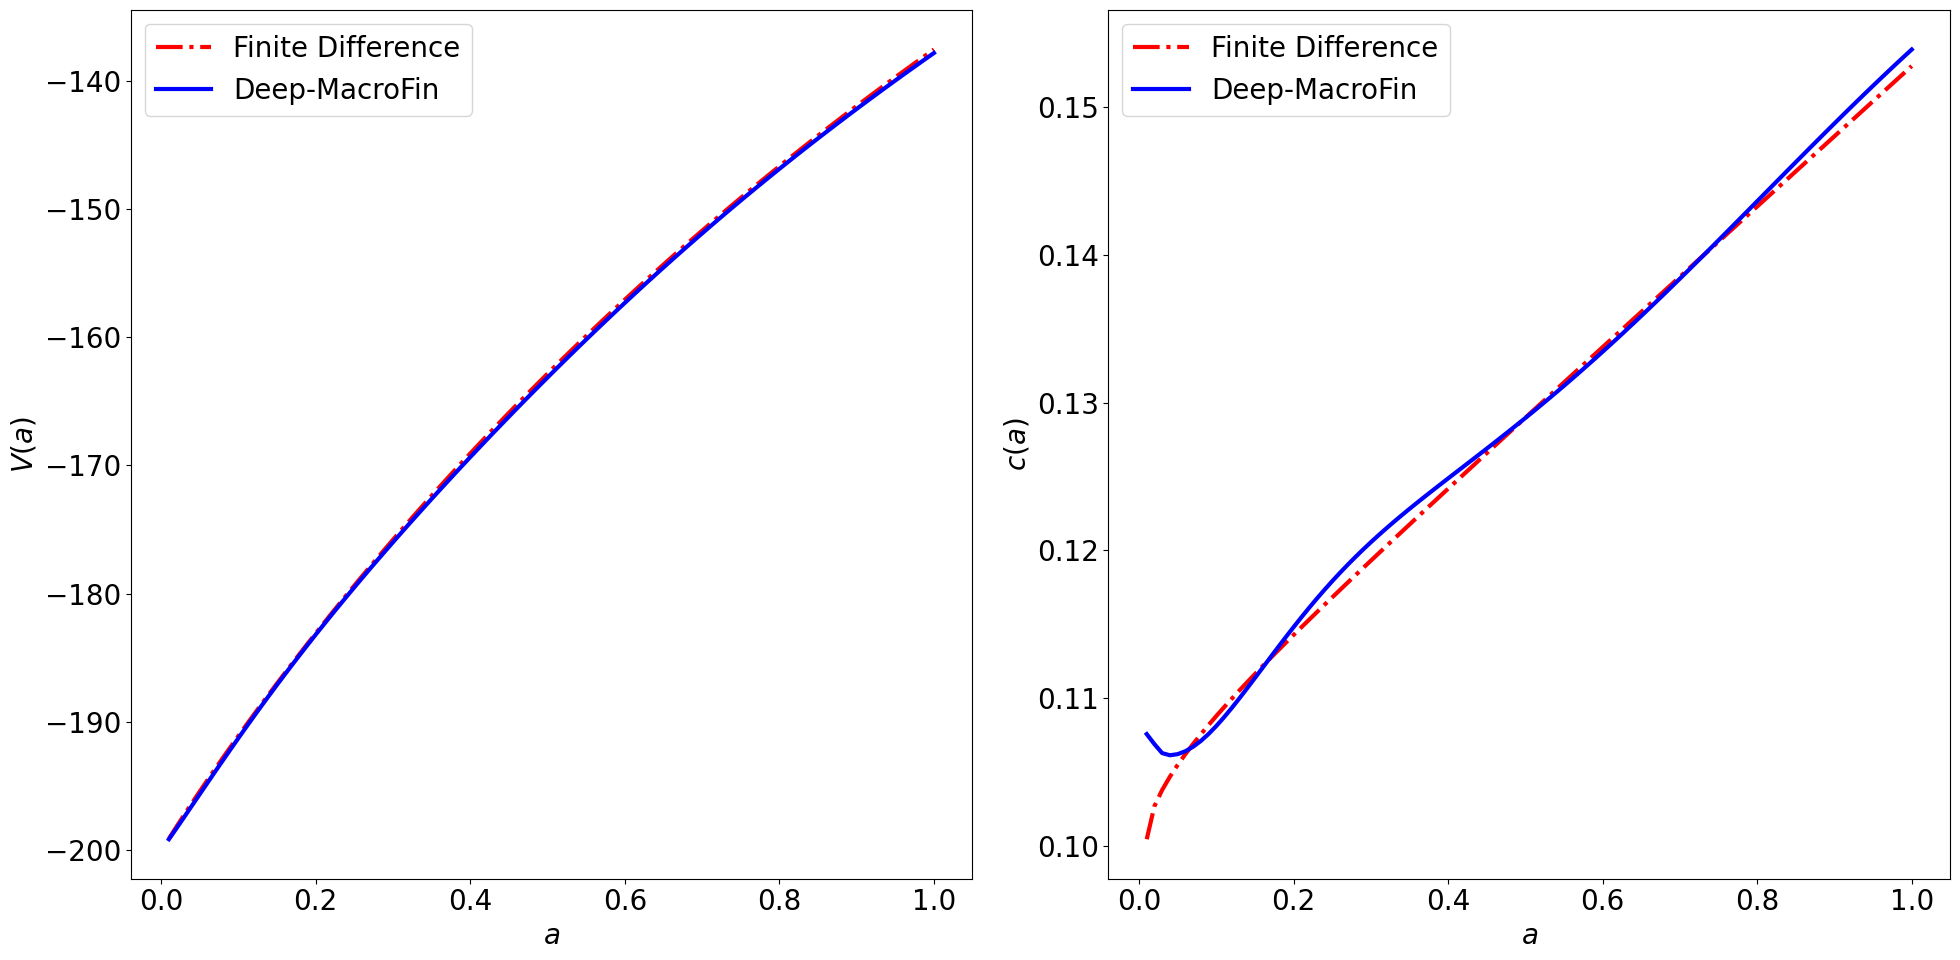

In [6]:
a_fd = fd_res["a"]
v_fd = fd_res["v"]
c_fd = fd_res["c"]

SV = torch.zeros((a_fd.shape[0], 2), device=model.device)
SV[:, 0] = torch.tensor(a_fd, device=model.device, dtype=torch.float32)
for i, sv_name in enumerate(model.state_variables):
    model.variable_val_dict[sv_name] = SV[:, i:i+1]
model.variable_val_dict["SV"] = SV
model.update_variables(SV)
V_model = model.variable_val_dict["V"].detach().cpu().numpy().reshape(-1)
c_model = model.variable_val_dict["c"].detach().cpu().numpy().reshape(-1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(a_fd, v_fd, linestyle="-.", color="red", label="Finite Difference")
ax[0].plot(a_fd, V_model, color="blue", label=f"Deep-MacroFin")
ax[0].legend()
ax[0].set_xlabel("$a$")
ax[0].set_ylabel("$V(a)$")

ax[1].plot(a_fd, c_fd, linestyle="-.", color="red", label="Finite Difference")
ax[1].plot(a_fd, c_model, color="blue", label=f"Deep-MacroFin")
ax[1].legend()
ax[1].set_xlabel("$a$")
ax[1].set_ylabel("$c(a)$")
plt.tight_layout()
plt.show()